In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# Path to the Dataset
direc = Path("/content/drive/MyDrive/ml/samples")

dir_img = sorted(list(map(str, list(direc.glob("*.png")))))
img_labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in dir_img]
char_img = set(char for label in img_labels for char in label)
char_img = sorted(list(char_img))


print("Number of dir_img found: ", len(dir_img))
print("Number of img_labels found: ", len(img_labels))
print("Number of unique char_img: ", len(char_img))
print("Characters present: ", char_img)


# Batch Size of Traning and Validation
batch_size = 16


# Setting dimensions of the image
img_width = 200
img_height = 50


# Setting downsampling factor
downsample_factor = 4


# Setting the Maximum Length
max_length = max([len(label) for label in img_labels])


# Char to integers
char_to_num = layers.StringLookup(
    vocabulary=list(char_img), mask_token=None
)


# Integers to original chaecters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


Number of dir_img found:  1040
Number of img_labels found:  1040
Number of unique char_img:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [4]:
def data_split(dir_img, img_labels, train_size=0.9, shuffle=True):
    # Get the total size of the dataset
    size = len(dir_img)
    # Create an indices array and shuffle it if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # Calculate the size of training samples
    train_samples = int(size * train_size)
    # Split data into training and validation sets
    x_train, y_train = dir_img[indices[:train_samples]], img_labels[indices[:train_samples]]
    x_valid, y_valid = dir_img[indices[train_samples:]], img_labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid




# Split data into training and validation sets
x_train, x_valid, y_train, y_valid = data_split(np.array(dir_img), np.array(img_labels))


In [5]:
def encode_sample(img_path, label):
    # Read the image
    img = tf.io.read_file(img_path)
    # Converting the image to grayscale
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resizing to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # Transposing the image
    img = tf.transpose(img, perm=[1, 0, 2])
    # Mapping image label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))

    return {"image": img, "label": label}

In [6]:
# Creating training dataset
dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset_train = (
    dataset_train.map(
        encode_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


# Creating validation dataset
val_data = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
val_data = (
    val_data.map(
        encode_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)




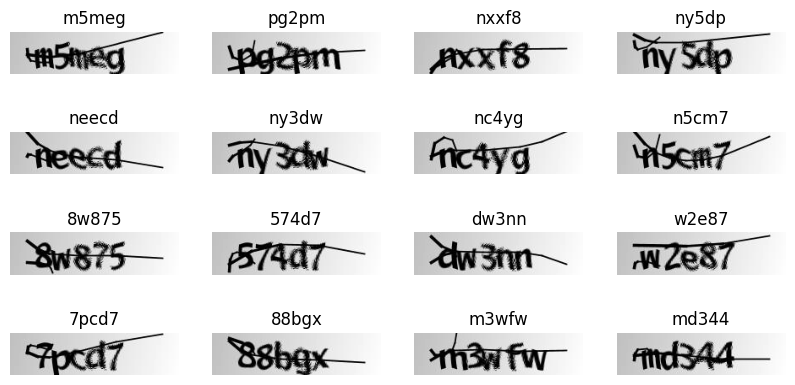

In [7]:
# Visualizing some training data
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in dataset_train.take(1):
    dir_img = batch["image"]
    img_labels = batch["label"]
    for i in range(16):
        img = (dir_img[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(img_labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()



In [8]:
# CTC loss calculation
class LayerCTC(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost


    def call(self, y_true, y_pred):
        # Compute the training-time loss value
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")


        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")


        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)


        # Return Computed predictions
        return y_pred




In [9]:
def model_build():
    # Define the inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    img_labels = layers.Input(name="label", shape=(None,), dtype="float32")


    # First convolutional block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)


    # Second convolutional block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)


    # Reshaping the output before passing to RNN
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)


    #RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)


    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)


    #Calculate CTC loss at each step
    output = LayerCTC(name="ctc_loss")(img_labels, x)


    # Defining the model
    model = keras.models.Model(
        inputs=[input_img, img_labels], outputs=output, name="ocr_model_v1"
    )
    opt = keras.optimizers.Adam()


    # Compile the model
    model.compile(optimizer=opt)


    return model




# Build the model
model = model_build()
model.summary()


# Early Stopping Parameters and EPOCH
epochs = 100
early_stopping_patience = 10


early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)


# Training the model
history = model.fit(
    dataset_train,
    validation_data=val_data,
    epochs=epochs,
    callbacks=[early_stopping],
)


Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                       

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

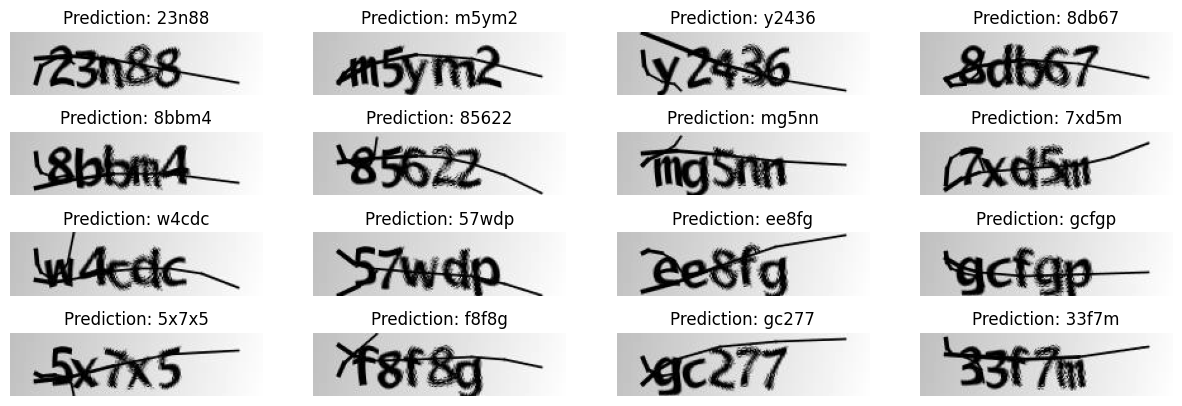

In [10]:
# Get the Model
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()



def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred,input_length=input_len, greedy=True)[0][0][ :, :max_length  ]
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text



# Check the validation on a few samples
for batch in val_data.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]


    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)


    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)


    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()




